In [9]:
import numpy as np
import matplotlib.pyplot as plt




## Functions


In [10]:
def build_stockoption_tree(S0, T, sigma, r, N):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    S = [[0 for j in range(N + 1)] for i in range(N + 1)]
    S[0][0] = S0
    for i in range(1, N + 1):  # Loop over time steps
        S[i][0] = S[i - 1][0] * np.exp(r*dt) * u  # First entry is an upward movement from previous
        for j in range(1, i + 1):  # Loop over the number of upward movements
            S[i][j] = S[i - 1][j - 1] *np.exp(r*dt)*d  # Downward movement from previous upward

    V = [[0 for j in range(N+1)] for i in range(N + 1)]

    for i in range(1, N + 1):  # Loop over time steps
        V[i][0] = np.maximum(K-S[i][0], 0)
        for j in range(1, i + 1):  # Loop over the number of upward movements
            V[i][j] = np.maximum(K-S[i][j], 0)
    return np.array(S), np.array(V)

In [11]:
def cal_exercise_boundary(S, V, K, r, dt, P, Q):
    #make a copy of V
    V1 = np.copy(V)
    exercise_boundary = {}
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            hold_value = np.exp(-r*dt)*(P*V1[i+1][j]+Q*V1[i+1][j+1])
            V1[i][j] = np.maximum(K-S[i][j], hold_value)
        for j in range(i + 1):
            if V1[i][j] == K - S[i][j]:  # Early exercise point
                exercise_boundary[i] = S[i, j]

                break
    return exercise_boundary, V1

In [12]:
def simulate_stock_path(S0, N, u, d, p,r,dt):
    """ Simulate a single stock price path using the binomial model. """
    #set seed

    S = np.zeros(N + 1)

    S[0] = S0
    for i in range(1, N + 1):
        if np.random.rand() < p:
            S[i] = S[i - 1] * np.exp(r*dt)* u  # Stock goes up
        else:
            S[i] = S[i - 1] * np.exp(r*dt) *d  # Stock goes down
    return S

In [13]:
def simulate_stock_paths(S0, N, u, d, p, num_paths, r, dt):
    """ Simulate multiple stock price paths using the binomial model in a vectorized way. """

    # Initialize the stock price matrix: each row is a path, each column is a time step
    S = np.zeros((num_paths, N + 1))

    # Set the initial stock price for all paths
    S[:, 0] = S0

    # Generate random numbers to decide if the stock goes up or down for each step and each path
    random_steps = np.random.rand(num_paths, N)

    # Create an array where we apply 'u' if random number < p, otherwise 'd'
    up_down_steps = np.where(random_steps < p, np.exp(r*dt)*u, np.exp(r*dt)*d)

    # Accumulate the stock prices along the paths (S[i] = S[i-1] * u or d for each step)
    S[:, 1:] = S0 * np.cumprod(up_down_steps, axis=1)


    return S

In [14]:

def calculate_delta(V, S, N):
    delta = np.zeros((N, N))  # Store delta for each time step
    for i in range(N):
        for j in range(i + 1):
            delta[i, j] = (V[i + 1, j] - V[i + 1, j + 1]) / (S[i + 1, j] - S[i + 1, j + 1])
    return delta

In [15]:
def get_hedging_strategy(path, delta_tree, N):
    """ Extract the delta values along a specific stock path. """
    hedge_strat = []
    node = 0  # Start at the root of the tree
    for i in range(N):
        hedge_strat.append(delta_tree[i, node])
        if path[i + 1] > path[i]:  # If the stock price went up
            node = node  # Stay in the same column
        else:  # If the stock price went down
            node = node + 1  # Move to the next column
    return hedge_strat

In [16]:
def select_path(S0, N, u, d, P, exercise_boundary, r, dt):

    #set seed
    window_size = 100
    num_paths = 1000
    paths = []
    for _ in range(num_paths):
        paths.append(simulate_stock_path(S0, N, u, d, P, r, dt))

    # Select a path where early exercise happens around t = T/2
    path_early_exercise = None
    path_no_exercise = None
    for path in paths:
        for i in range(N // 2 - window_size, N // 2 + window_size + 1):  # Check within a window
            if path[i] < exercise_boundary[i]:
                if all(path[j] <= exercise_boundary[j] for j in range(i + 1, N)):
                    path_early_exercise = path #for demonstration purpose: pick the one that never goes below the boundary again
                    break  # Select this path since it crosses within the time window
        if path_early_exercise is not None:
            break

    # Select a path where no early exercise happens (i.e., it never falls below the boundary)
    for path in paths:
        if all(path[i] > exercise_boundary[i] for i in list(exercise_boundary.keys())) and path[-1] > 10:
            path_no_exercise = path
            break

    return path_early_exercise, path_no_exercise

In [17]:
def plot_boundary_delta(exercise_boundary, path_early_exercise,path_no_exercise, hedge_early, hedge_no_exercise):
    time = np.linspace(0, 5000, N + 1)


    plt.figure(figsize=(15, 15))

    plt.subplot(2, 2, 1)
    plt.plot(time, path_early_exercise, label="Path (Exercised Early)")
    plt.plot(list(exercise_boundary.keys()), list(exercise_boundary.values()), 'r--', label="Exercise Boundary")
    plt.axvline(x=2500, color='r', linestyle='--', label="t = T/2")
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title('Sample Stock Price Paths and Exercise Boundary')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(list(exercise_boundary.keys()), list(exercise_boundary.values()), 'r--', label="Exercise Boundary")
    plt.plot(time, path_no_exercise, label="Path (Not Exercised)", c = 'green')
    plt.axvline(x=2500, color='r', linestyle='--', label="t = T/2")
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title('Sample Stock Price Paths and Exercise Boundary')
    plt.legend()
    plt.grid(True)



    time = np.linspace(0, T, N)
    plt.subplot(2,2,3)
    plt.plot(time, hedge_early, label="Hedging Strategy (Exercised Early)")
    plt.xlabel('Time')
    plt.ylabel('Delta (Hedging Strategy)')
    plt.title('Hedging Strategy Over Time for American Put Option')
    plt.legend()
    plt.grid(True)
    plt.subplot(2,2,4)
    plt.plot(time, hedge_no_exercise, label="Hedging Strategy (Not Exercised)")
    plt.xlabel('Time')
    plt.ylabel('Delta (Hedging Strategy)')
    plt.title('Hedging Strategy Over Time for American Put Option')
    plt.legend()
    plt.grid(True)

    plt.show()

## Q2 a


In [10]:
# Parameters
S0 = 10      # Initial stock price
T = 1        # Time to maturity (in years)
sigma = 0.20 # Volatility
r = 0.02     # Risk-free rate
N = 5000       # Number of time steps (for this small example)
dt = T / N   # Time step size
mu = 0.05
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u    # Down factor
K = 10



In [11]:
S,V = build_stockoption_tree(S0, T, sigma, r, N)


In [12]:
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn

P_real = 1/2 * (1 + ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
Q_real = 1/2 * (1 - ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)

In [13]:
print(P_rn, Q_rn)
print(P_real, Q_real)

0.49929289369021757 0.5007071063097824
0.5003535533905933 0.4996464466094067


#### Exercise boundary (risk neutral) Q2a (i)

We calculate exercise boundary by the following, for each time step, get the first node of which Max(K-S, 0) > Hold value = Expected value of holding the option at that time, discounted to the current node.

For that node, get the stock price at that node.

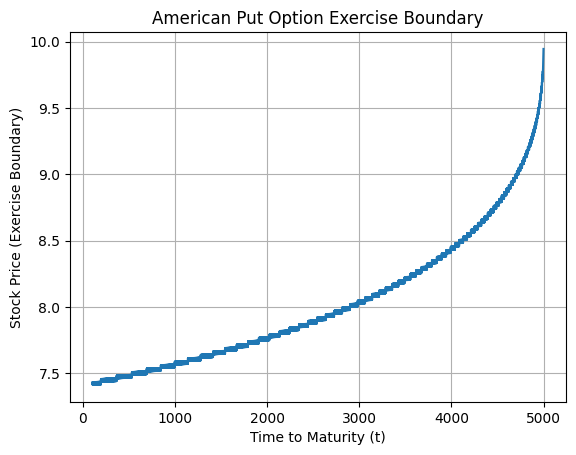

In [14]:


exercise_boundary_rn, V1_rn = cal_exercise_boundary(S, V, K, r, dt, P_rn, Q_rn)


plt.plot(list(exercise_boundary_rn.keys()), list(exercise_boundary_rn.values()), label = 'Risk Neutral')



plt.xlabel('Time to Maturity (t)')
plt.ylabel('Stock Price (Exercise Boundary)')
plt.title('American Put Option Exercise Boundary')
plt.grid(True)
plt.show()




In [15]:
print("The American put option price is: ", V1_rn[0][0])

The American put option price is:  0.7111204377877869


#### Exercise boundary, path, and delta (risk neutral and real world default setting) Q2a (ii) + (iii)

In [16]:
path_early_exercise_rn, path_no_exercise_rn = select_path(S0, N, u, d, P_real, exercise_boundary_rn, r, dt)


# Risk Neutral
delta_tree = calculate_delta(V1_rn, S, N)
hedge_early = get_hedging_strategy(path_early_exercise_rn, delta_tree, N)
hedge_no_exercise = get_hedging_strategy(path_no_exercise_rn, delta_tree, N)




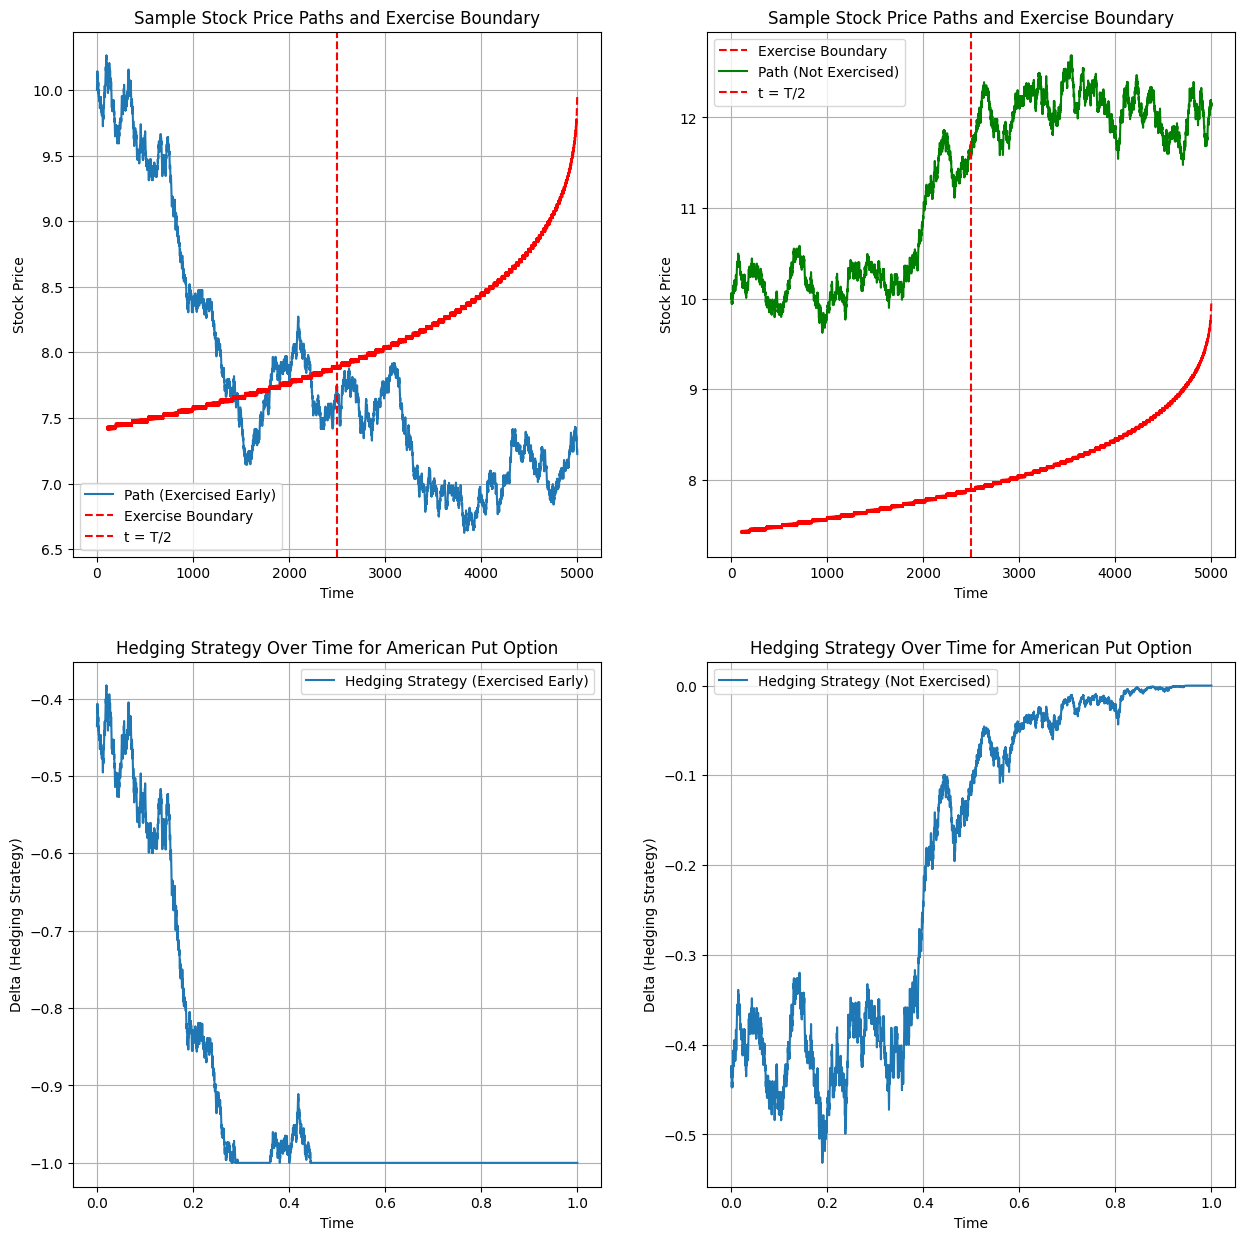

In [17]:
# Risk Neutral
plot_boundary_delta(exercise_boundary_rn, path_early_exercise_rn,path_no_exercise_rn, hedge_early, hedge_no_exercise)



When an American put option is early exercised, Delta becomes -1 because the option behaves like a short position in the stock, where each $1 decrease in the stock price results in a $1 increase in the option’s payoff. In contrast, if the option is never exercised and remains out of the money, Delta approaches 0 because the option becomes less sensitive to changes in the stock price, as it is unlikely to be exercised and its value diminishes.

### Comparison for different sigma and risk free rates

### sigma = 10%, r = 0%

In [18]:
# Parameters
S0 = 10      # Initial stock price
T = 1        # Time to maturity (in years)
sigma = 0.1 # Volatility
r = 0    # Risk-free rate
N = 5000       # Number of time steps (for this small example)
dt = T / N   # Time step size
mu = 0.05
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u    # Down factor
K = 10

In [19]:
S,V = build_stockoption_tree(S0, T, sigma, r, N)
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn


KeyboardInterrupt: 

In [20]:
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn

P_real = 1/2 * (1 + ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
Q_real = 1/2 * (1 - ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)

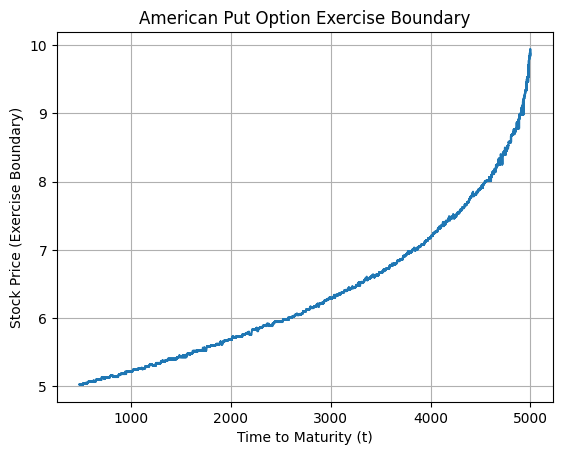

In [21]:

exercise_boundary_rn, V1_rn = cal_exercise_boundary(S, V, K, r, dt, P_rn, Q_rn)


plt.plot(list(exercise_boundary_rn.keys()), list(exercise_boundary_rn.values()), label = 'Risk Neutral')



plt.xlabel('Time to Maturity (t)')
plt.ylabel('Stock Price (Exercise Boundary)')
plt.title('American Put Option Exercise Boundary')
plt.grid(True)
plt.show()


In [22]:
print("The American put option price is: ", V1_rn[0][0])

The American put option price is:  0.3987561784683149


We observe a very low exercise boundary for risk neutral measure, which means that when r = 0%, early exercise is very not encouraged.



In [23]:
path_early_exercise_rn, path_no_exercise_rn = select_path(S0, N, u, d, P_real, exercise_boundary_rn, r, dt)







In [24]:
print(path_early_exercise_rn)


None


This confirms the observation of the early exercise is very not encouraged.

In [25]:
# Risk Neutral
delta_tree = calculate_delta(V1_rn, S, N)

hedge_no_exercise = get_hedging_strategy(path_no_exercise_rn, delta_tree, N)

This indicates that when r = 0, generally, its never optimal to early exercise a American Put Option under risk neutral measure. This is because the main advantage of early exercise typically comes from the time value of money, which diminishes when r=0



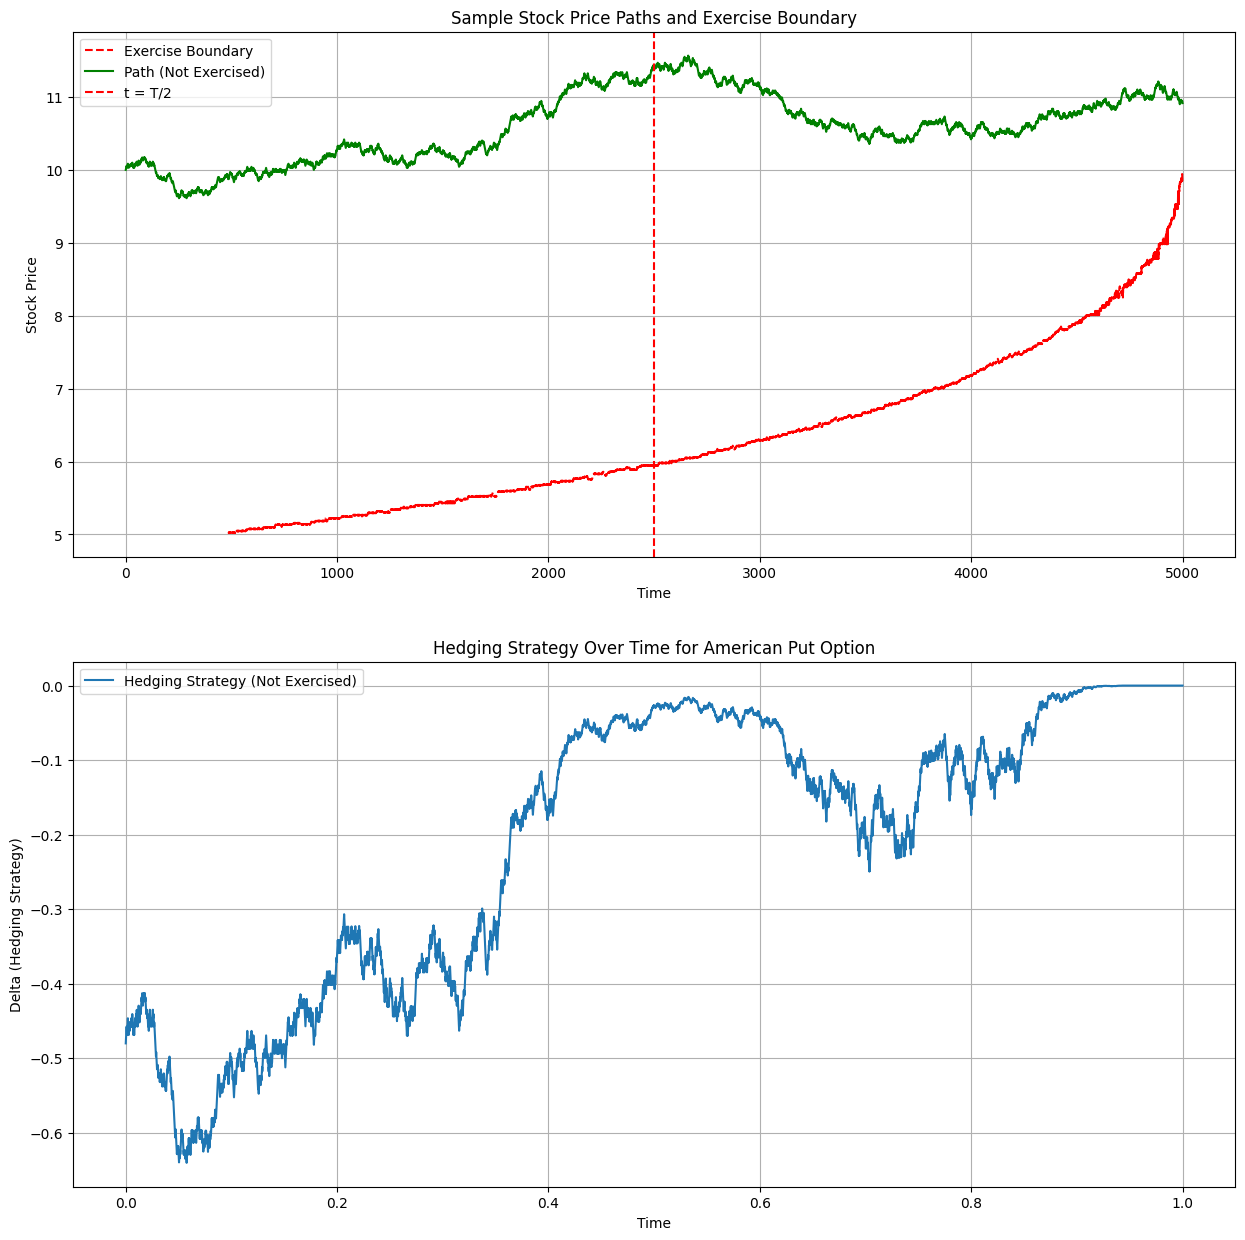

In [26]:
#Risk Neutral

time = np.linspace(0, N, N + 1)


plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 1)



plt.plot(list(exercise_boundary_rn.keys()), list(exercise_boundary_rn.values()), 'r--', label="Exercise Boundary")
plt.plot(time, path_no_exercise_rn, label="Path (Not Exercised)", c = 'green')
plt.axvline(x=2500, color='r', linestyle='--', label="t = T/2")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Sample Stock Price Paths and Exercise Boundary')
plt.legend()
plt.grid(True)



time = np.linspace(0, T, N)

plt.subplot(2,1,2)
plt.plot(time, hedge_no_exercise, label="Hedging Strategy (Not Exercised)")
plt.xlabel('Time')
plt.ylabel('Delta (Hedging Strategy)')
plt.title('Hedging Strategy Over Time for American Put Option')
plt.legend()
plt.grid(True)

plt.show()

### sigma = 10%, r = 2%

In [27]:
# Parameters
S0 = 10      # Initial stock price
T = 1        # Time to maturity (in years)
sigma = 0.1 # Volatility
r = 0.02     # Risk-free rate
N = 5000       # Number of time steps (for this small example)
dt = T / N   # Time step size
mu = 0.05
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u    # Down factor
K = 10

In [28]:
S,V = build_stockoption_tree(S0, T, sigma, r, N)
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn

In [29]:
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn

P_real = 1/2 * (1 + ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
Q_real = 1/2 * (1 - ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)

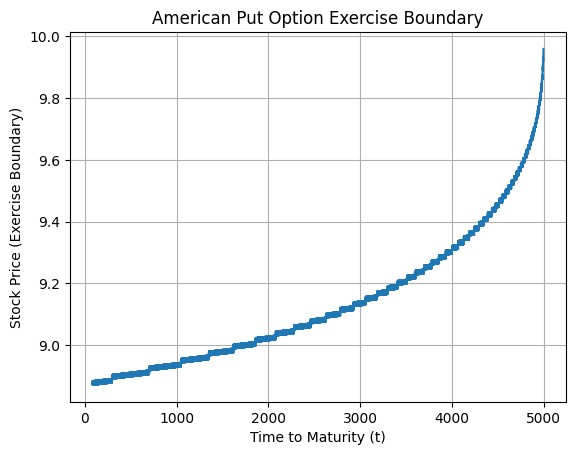

In [30]:
exercise_boundary_rn, V1_rn = cal_exercise_boundary(S, V, K, r, dt, P_rn, Q_rn)


plt.plot(list(exercise_boundary_rn.keys()), list(exercise_boundary_rn.values()), label = 'Risk Neutral')



plt.xlabel('Time to Maturity (t)')
plt.ylabel('Stock Price (Exercise Boundary)')
plt.title('American Put Option Exercise Boundary')
plt.grid(True)
plt.show()

In [31]:
print("The American put option price is: ", V1_rn[0][0])

The American put option price is:  0.32248618887377656


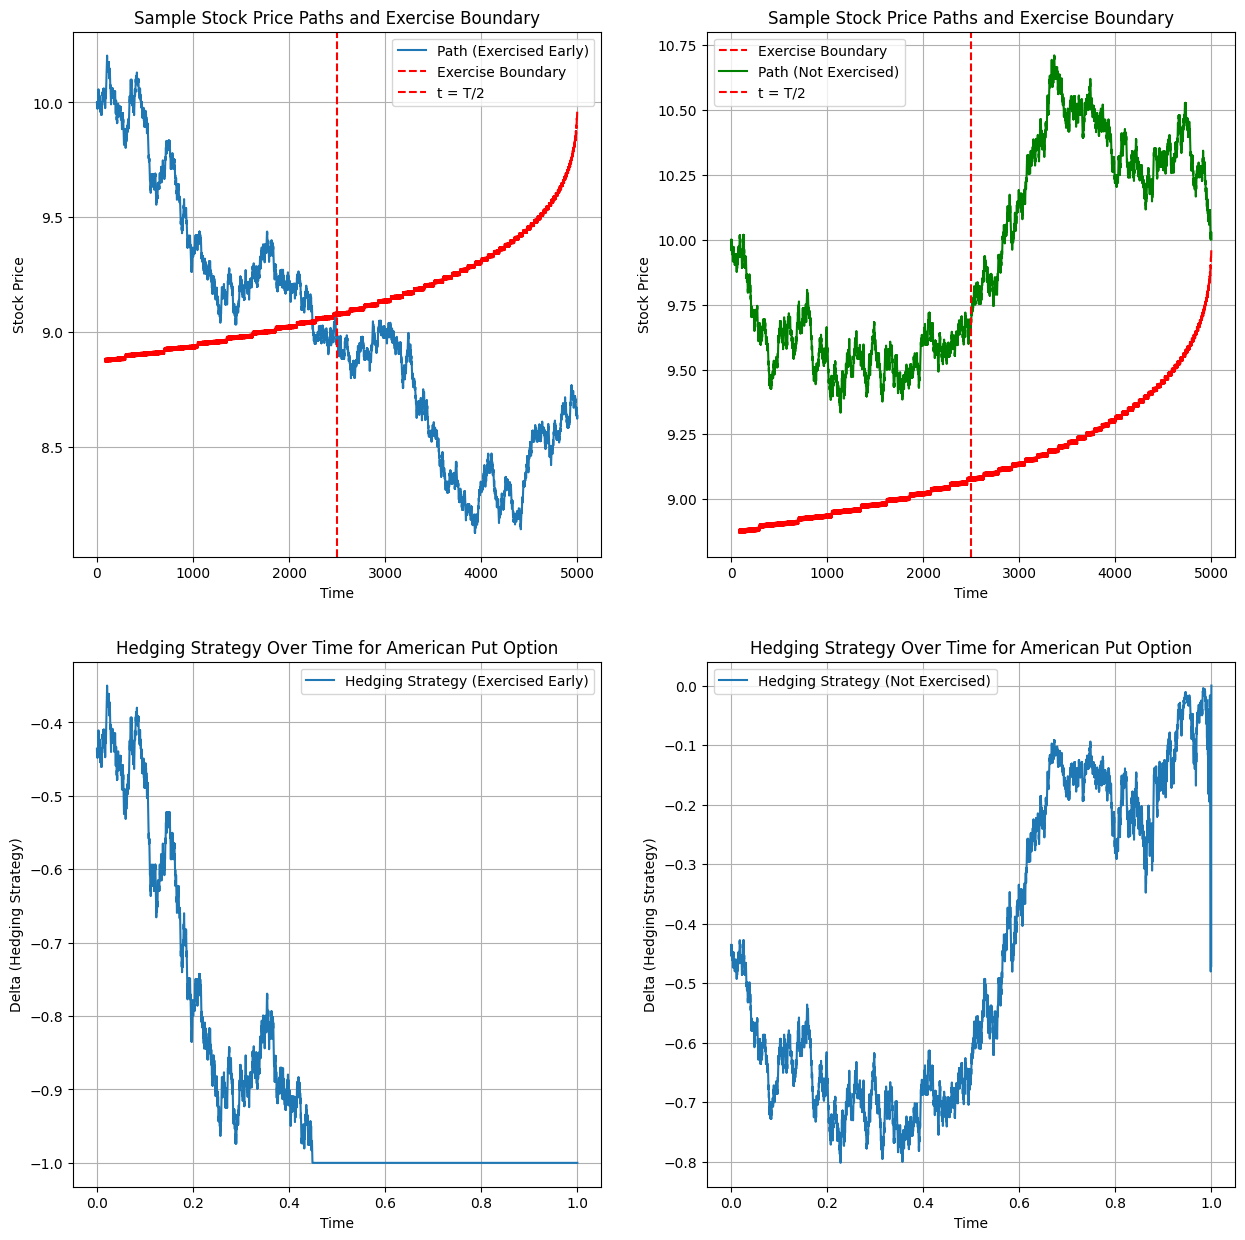

In [32]:
path_early_exercise_rn, path_no_exercise_rn = select_path(S0, N, u, d, P_real, exercise_boundary_rn, r, dt)


# Risk Neutral
delta_tree = calculate_delta(V1_rn, S, N)
hedge_early = get_hedging_strategy(path_early_exercise_rn, delta_tree, N)
hedge_no_exercise = get_hedging_strategy(path_no_exercise_rn, delta_tree, N)

# Risk Neutral
plot_boundary_delta(exercise_boundary_rn, path_early_exercise_rn,path_no_exercise_rn, hedge_early, hedge_no_exercise)

### sigma = 10%, r = 4%

In [33]:
# Parameters
S0 = 10      # Initial stock price
T = 1        # Time to maturity (in years)
sigma = 0.10 # Volatility
r = 0.04     # Risk-free rate
N = 5000       # Number of time steps (for this small example)
dt = T / N   # Time step size
mu = 0.05
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u    # Down factor
K = 10


In [34]:
S,V = build_stockoption_tree(S0, T, sigma, r, N)
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn

In [35]:
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn

P_real = 1/2 * (1 + ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
Q_real = 1/2 * (1 - ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)

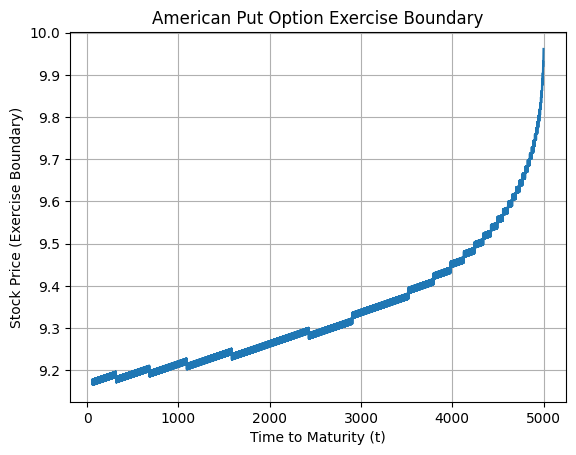

In [36]:
exercise_boundary_rn, V1_rn = cal_exercise_boundary(S, V, K, r, dt, P_rn, Q_rn)


plt.plot(list(exercise_boundary_rn.keys()), list(exercise_boundary_rn.values()), label = 'Risk Neutral')



plt.xlabel('Time to Maturity (t)')
plt.ylabel('Stock Price (Exercise Boundary)')
plt.title('American Put Option Exercise Boundary')
plt.grid(True)
plt.show()

In [37]:
print("The American put option price is: ", V1_rn[0][0])

The American put option price is:  0.2665292252826185


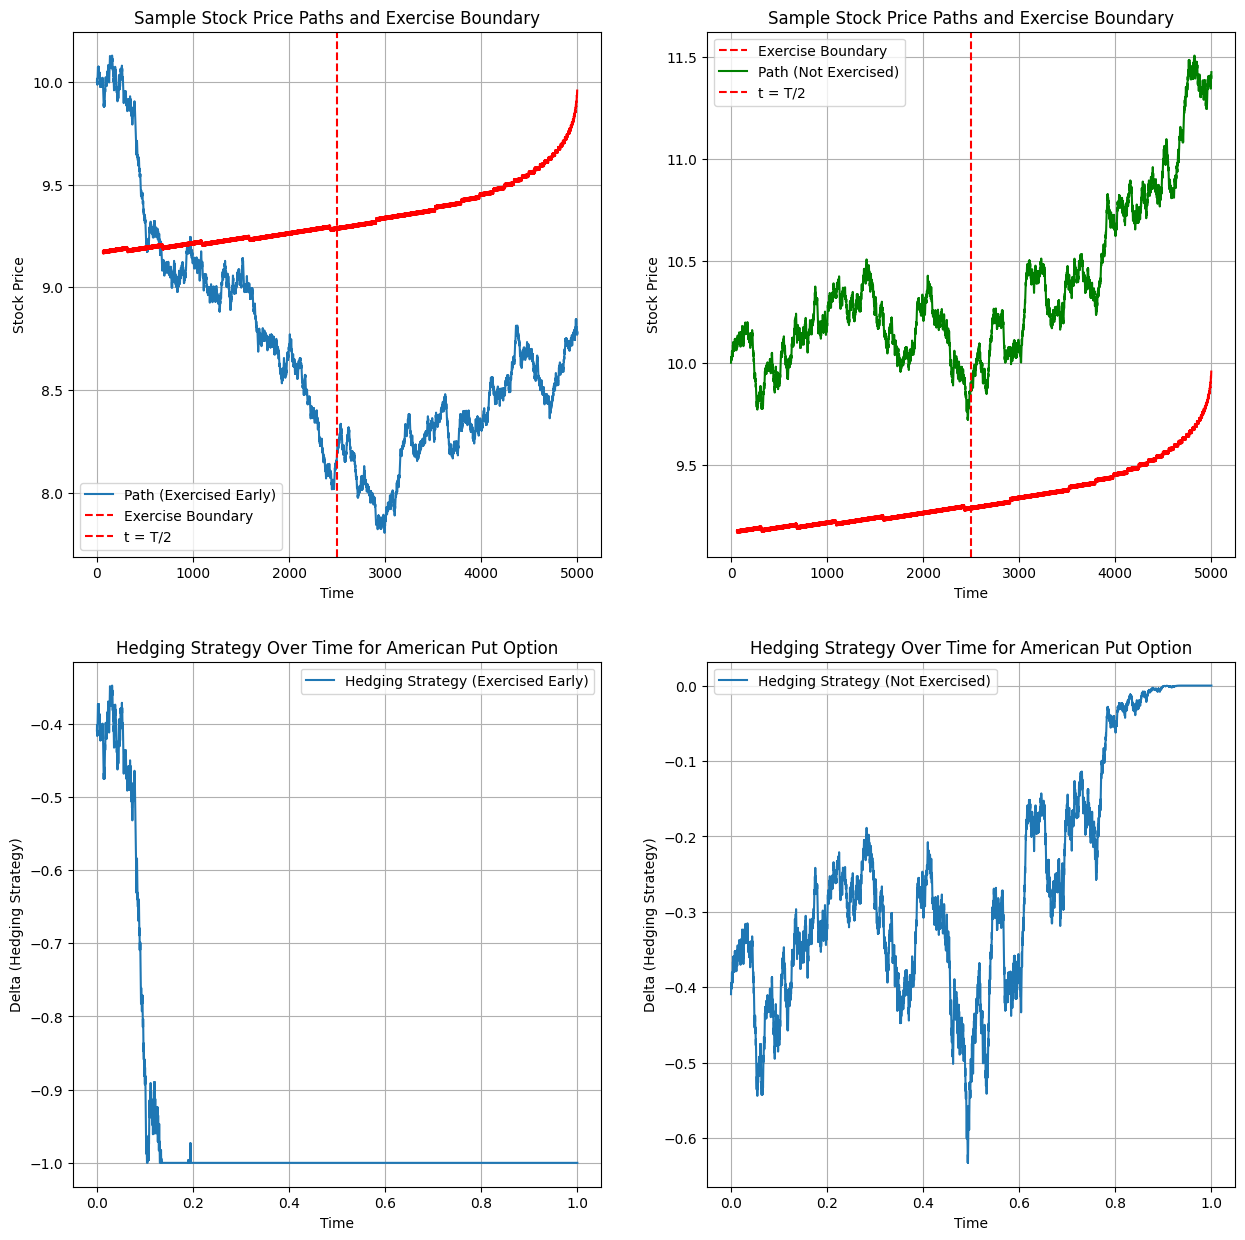

In [38]:
path_early_exercise_rn, path_no_exercise_rn = select_path(S0, N, u, d, P_real, exercise_boundary_rn,r,dt)


# Risk Neutral
delta_tree = calculate_delta(V1_rn, S, N)
hedge_early = get_hedging_strategy(path_early_exercise_rn, delta_tree, N)
hedge_no_exercise = get_hedging_strategy(path_no_exercise_rn, delta_tree, N)

# Risk Neutral
plot_boundary_delta(exercise_boundary_rn, path_early_exercise_rn,path_no_exercise_rn, hedge_early, hedge_no_exercise)

### sigma = 20%, r = 0%

In [39]:
# Parameters
S0 = 10      # Initial stock price
T = 1        # Time to maturity (in years)
sigma = 0.2 # Volatility
r = 0   # Risk-free rate
N = 5000       # Number of time steps (for this small example)
dt = T / N   # Time step size
mu = 0.05
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u    # Down factor
K = 10

In [40]:
S,V = build_stockoption_tree(S0, T, sigma, r, N)
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn

In [41]:
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn

P_real = 1/2 * (1 + ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
Q_real = 1/2 * (1 - ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)

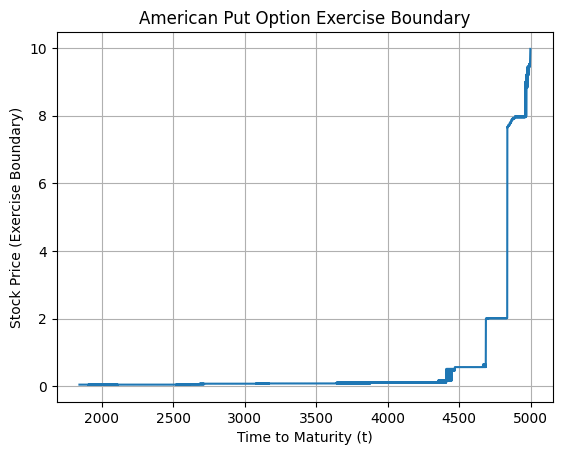

In [42]:
exercise_boundary_rn, V1_rn = cal_exercise_boundary(S, V, K, r, dt, P_rn, Q_rn)


plt.plot(list(exercise_boundary_rn.keys()), list(exercise_boundary_rn.values()), label = 'Risk Neutral')



plt.xlabel('Time to Maturity (t)')
plt.ylabel('Stock Price (Exercise Boundary)')
plt.title('American Put Option Exercise Boundary')
plt.grid(True)
plt.show()


In [44]:
print("The American put option price is: ", V1_rn[0][0])

The American put option price is:  0.7965169189646462


In [45]:
path_early_exercise_rn, path_no_exercise_rn = select_path(S0, N, u, d, P_real, exercise_boundary_rn,r,dt)
print(path_early_exercise_rn)


None


In [46]:
# Risk Neutral
delta_tree = calculate_delta(V1_rn, S, N)

hedge_no_exercise = get_hedging_strategy(path_no_exercise_rn, delta_tree, N)

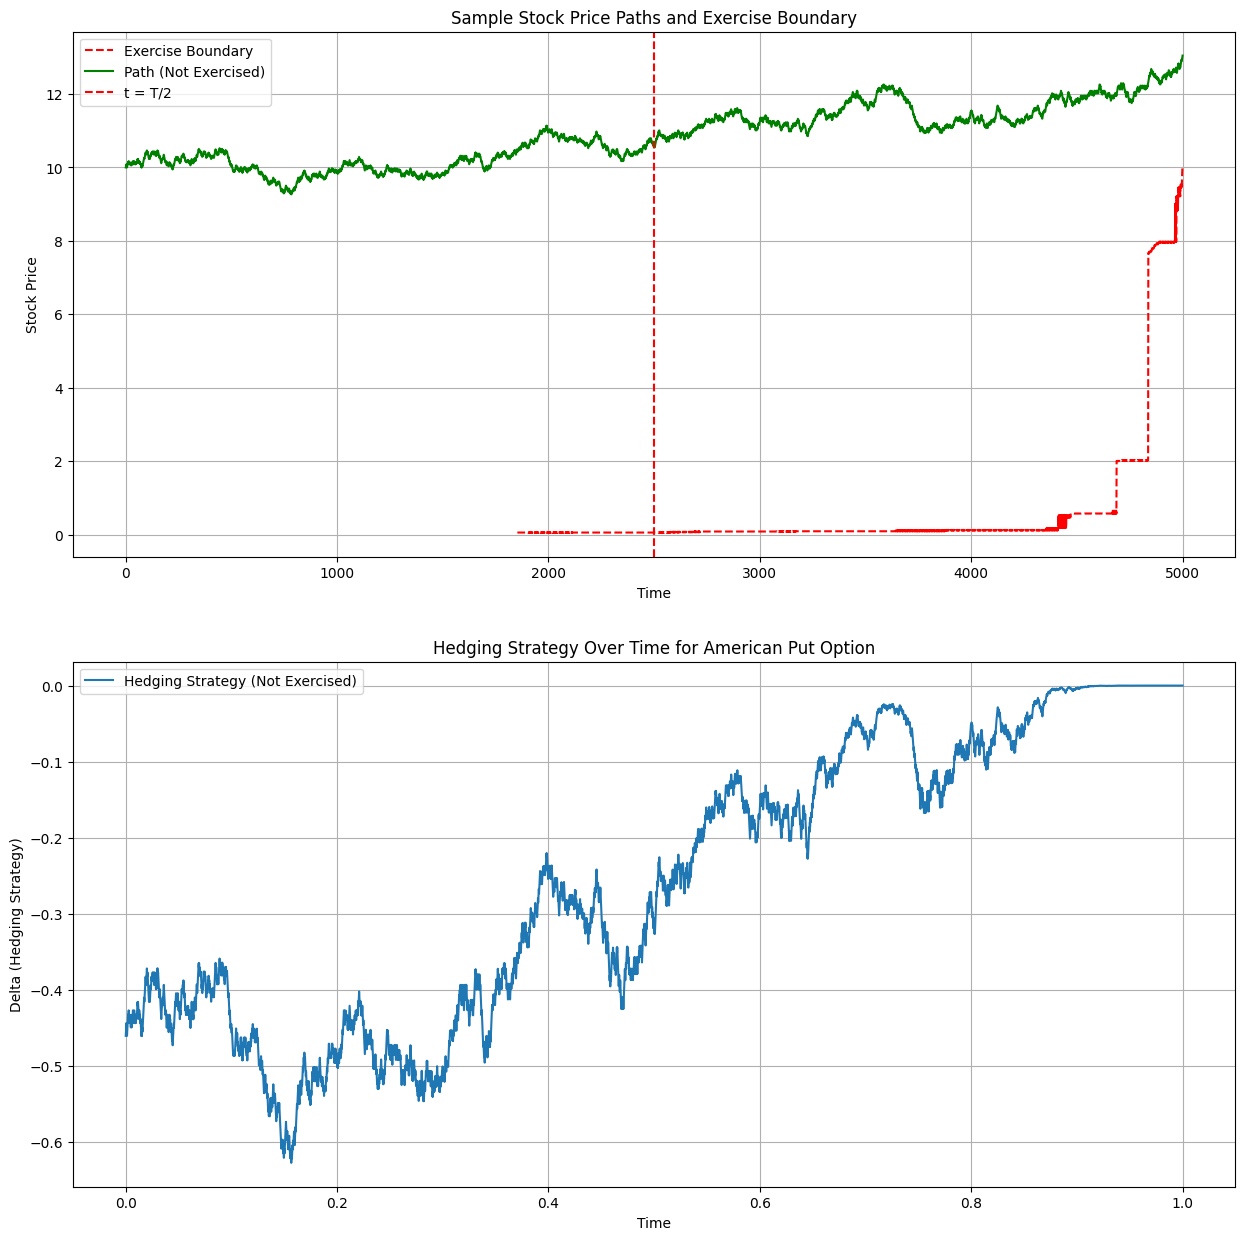

In [47]:
#Risk Neutral

time = np.linspace(0, N, N + 1)


plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 1)



plt.plot(list(exercise_boundary_rn.keys()), list(exercise_boundary_rn.values()), 'r--', label="Exercise Boundary")
plt.plot(time, path_no_exercise_rn, label="Path (Not Exercised)", c = 'green')
plt.axvline(x=2500, color='r', linestyle='--', label="t = T/2")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Sample Stock Price Paths and Exercise Boundary')
plt.legend()
plt.grid(True)



time = np.linspace(0, T, N)

plt.subplot(2,1,2)
plt.plot(time, hedge_no_exercise, label="Hedging Strategy (Not Exercised)")
plt.xlabel('Time')
plt.ylabel('Delta (Hedging Strategy)')
plt.title('Hedging Strategy Over Time for American Put Option')
plt.legend()
plt.grid(True)

plt.show()

### sigma = 30%, r = 0%

In [48]:
# Parameters
S0 = 10      # Initial stock price
T = 1        # Time to maturity (in years)
sigma = 0.30 # Volatility
r = 0     # Risk-free rate
N = 5000       # Number of time steps (for this small example)
dt = T / N   # Time step size
mu = 0.05
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u    # Down factor
K = 10


In [49]:
S,V = build_stockoption_tree(S0, T, sigma, r, N)
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn

In [50]:
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn

P_real = 1/2 * (1 + ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
Q_real = 1/2 * (1 - ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)

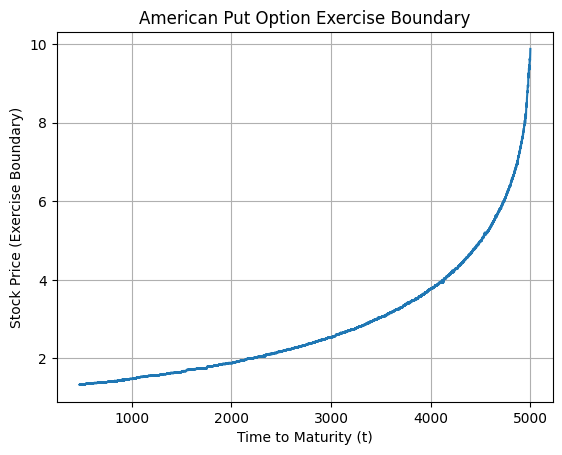

In [51]:
exercise_boundary_rn, V1_rn = cal_exercise_boundary(S, V, K, r, dt, P_rn, Q_rn)


plt.plot(list(exercise_boundary_rn.keys()), list(exercise_boundary_rn.values()), label = 'Risk Neutral')



plt.xlabel('Time to Maturity (t)')
plt.ylabel('Stock Price (Exercise Boundary)')
plt.title('American Put Option Exercise Boundary')
plt.grid(True)
plt.show()


In [52]:
print("The American put option price is: ", V1_rn[0][0])

The American put option price is:  1.1922942332061912


In [53]:
path_early_exercise_rn, path_no_exercise_rn = select_path(S0, N, u, d, P_real, exercise_boundary_rn,r,dt)
print(path_early_exercise_rn)

None


In [54]:
# Risk Neutral
delta_tree = calculate_delta(V1_rn, S, N)

hedge_no_exercise = get_hedging_strategy(path_no_exercise_rn, delta_tree, N)

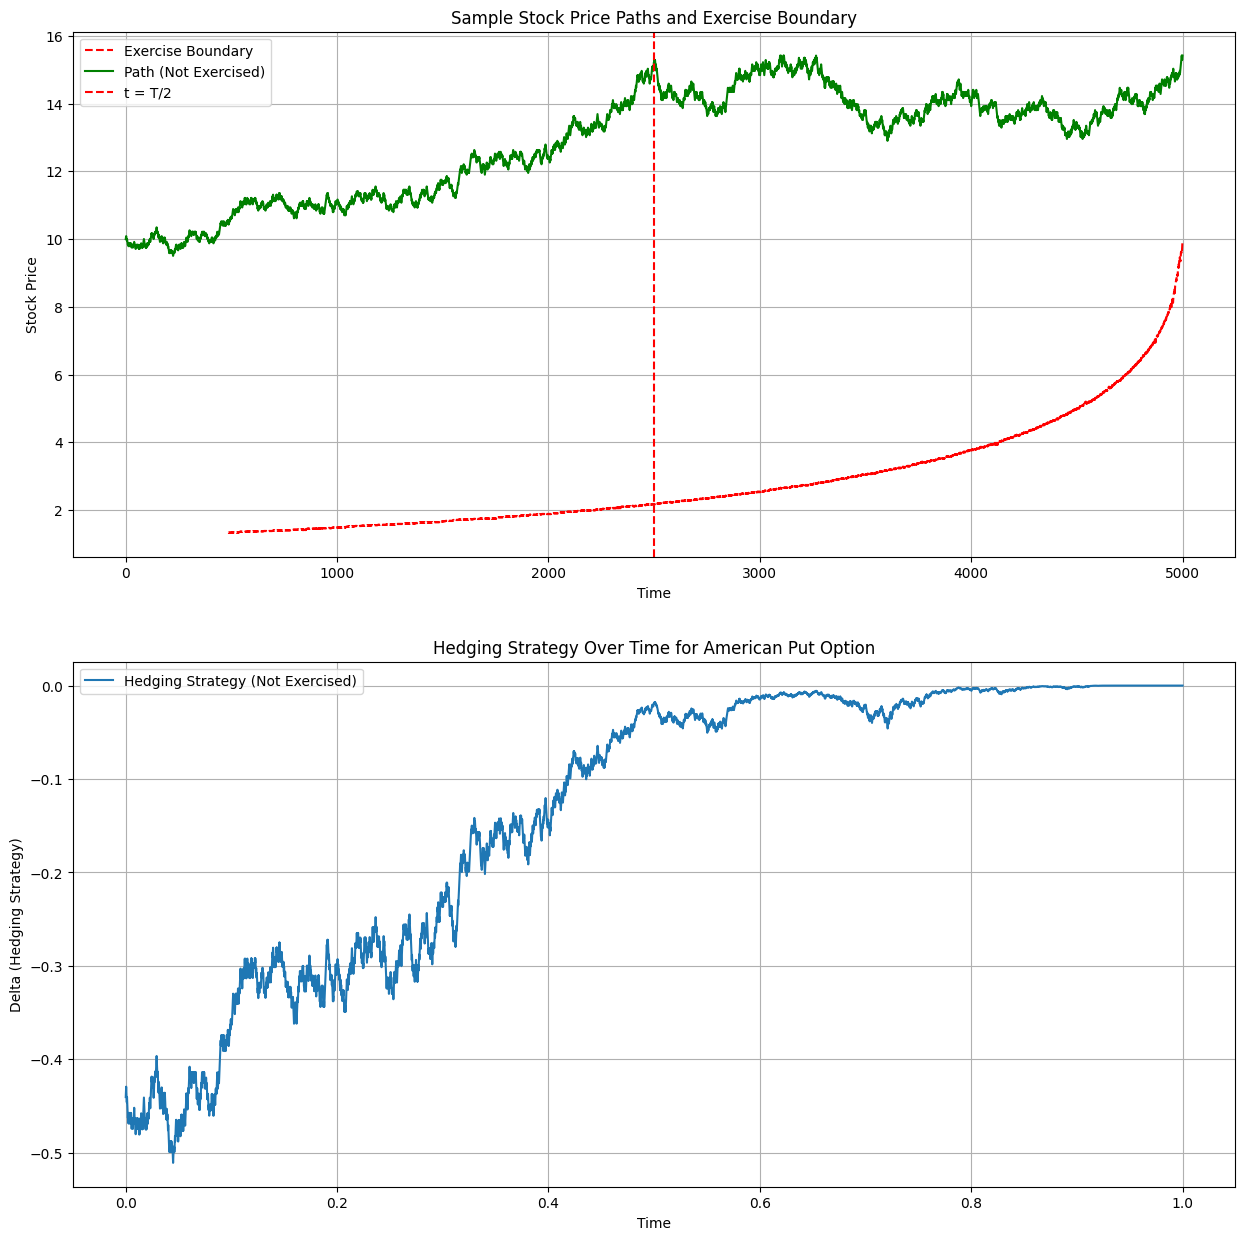

In [55]:
#Risk Neutral

time = np.linspace(0, N, N + 1)


plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 1)



plt.plot(list(exercise_boundary_rn.keys()), list(exercise_boundary_rn.values()), 'r--', label="Exercise Boundary")
plt.plot(time, path_no_exercise_rn, label="Path (Not Exercised)", c = 'green')
plt.axvline(x=2500, color='r', linestyle='--', label="t = T/2")
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Sample Stock Price Paths and Exercise Boundary')
plt.legend()
plt.grid(True)



time = np.linspace(0, T, N)

plt.subplot(2,1,2)
plt.plot(time, hedge_no_exercise, label="Hedging Strategy (Not Exercised)")
plt.xlabel('Time')
plt.ylabel('Delta (Hedging Strategy)')
plt.title('Hedging Strategy Over Time for American Put Option')
plt.legend()
plt.grid(True)

plt.show()

### sigma = 30%, r = 2%

In [56]:
# Parameters
S0 = 10      # Initial stock price
T = 1        # Time to maturity (in years)
sigma = 0.30 # Volatility
r = 0.02    # Risk-free rate
N = 5000       # Number of time steps (for this small example)
dt = T / N   # Time step size
mu = 0.05
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u    # Down factor
K = 10

In [57]:
S,V = build_stockoption_tree(S0, T, sigma, r, N)
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn


In [58]:
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn

P_real = 1/2 * (1 + ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
Q_real = 1/2 * (1 - ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)

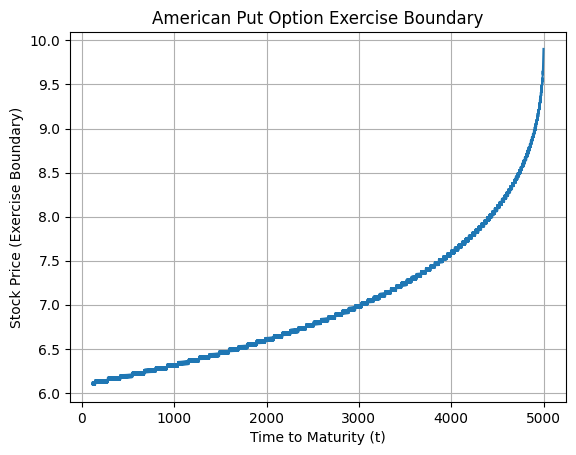

In [59]:
exercise_boundary_rn, V1_rn = cal_exercise_boundary(S, V, K, r, dt, P_rn, Q_rn)


plt.plot(list(exercise_boundary_rn.keys()), list(exercise_boundary_rn.values()), label = 'Risk Neutral')



plt.xlabel('Time to Maturity (t)')
plt.ylabel('Stock Price (Exercise Boundary)')
plt.title('American Put Option Exercise Boundary')
plt.grid(True)
plt.show()


In [60]:
print("The American put option price is: ", V1_rn[0][0])

The American put option price is:  1.101376454237933


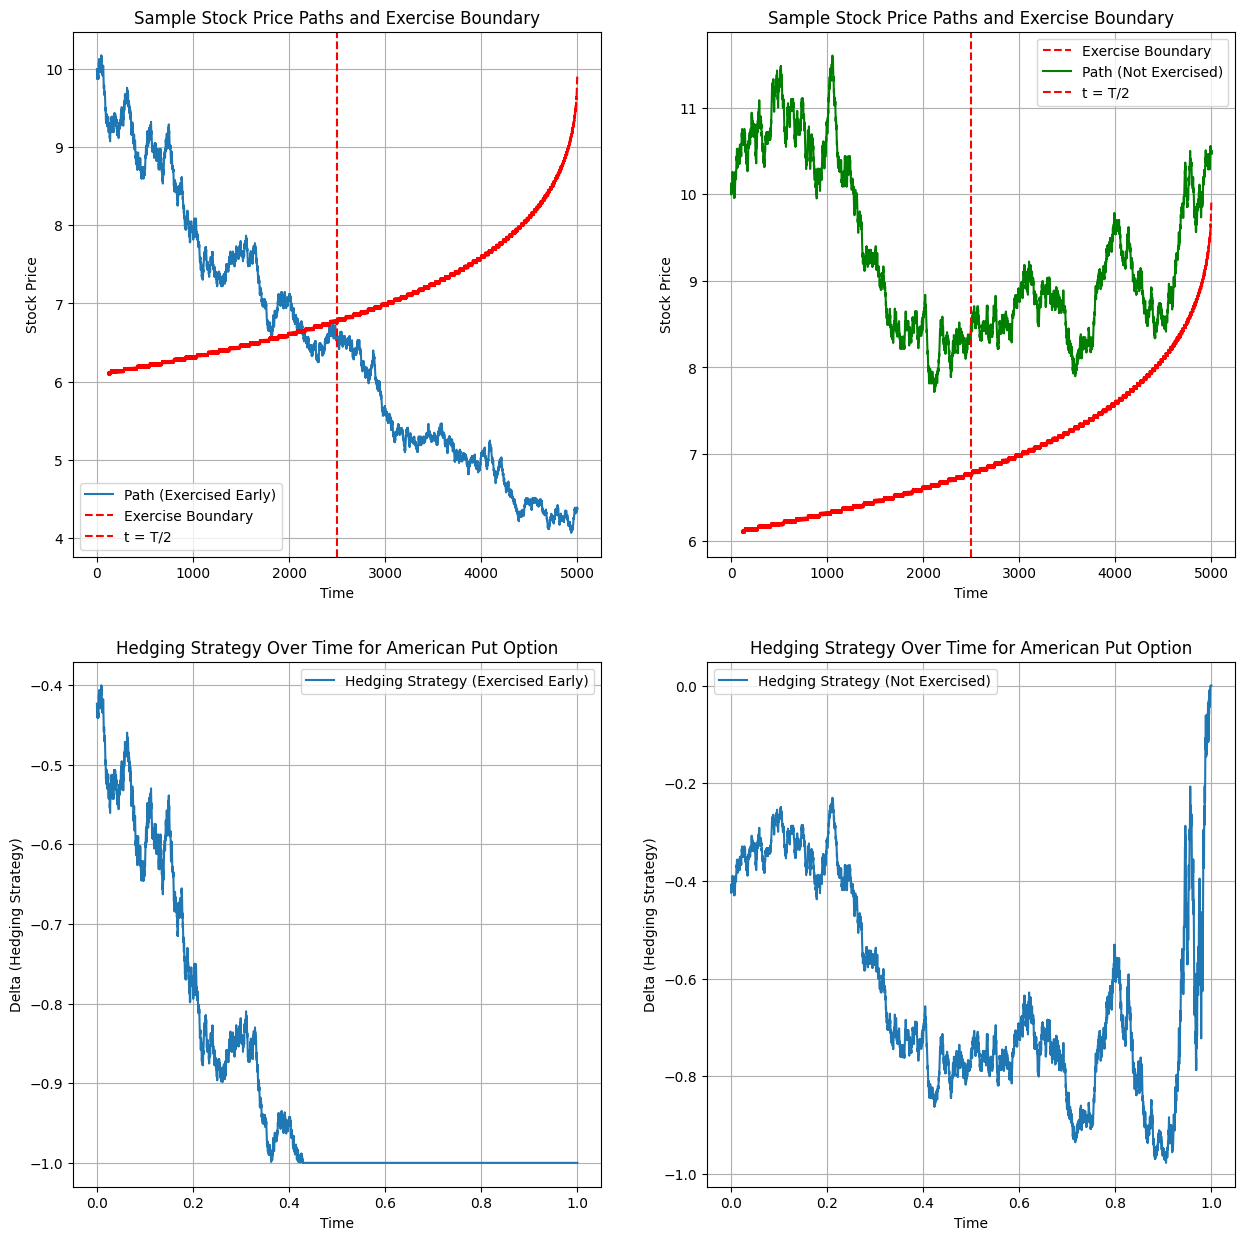

In [61]:
path_early_exercise_rn, path_no_exercise_rn = select_path(S0, N, u, d, P_real, exercise_boundary_rn,r,dt)


# Risk Neutral
delta_tree = calculate_delta(V1_rn, S, N)
hedge_early = get_hedging_strategy(path_early_exercise_rn, delta_tree, N)
hedge_no_exercise = get_hedging_strategy(path_no_exercise_rn, delta_tree, N)

# Risk Neutral
plot_boundary_delta(exercise_boundary_rn, path_early_exercise_rn,path_no_exercise_rn, hedge_early, hedge_no_exercise)

### sigma = 30%, r = 4%

In [63]:
# Parameters
S0 = 10      # Initial stock price
T = 1        # Time to maturity (in years)
sigma = 0.30 # Volatility
r = 0.04     # Risk-free rate
N = 5000       # Number of time steps (for this small example)
dt = T / N   # Time step size
mu = 0.05
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u    # Down factor
K = 10


In [64]:
S,V = build_stockoption_tree(S0, T, sigma, r, N)
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn


In [65]:
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn

P_real = 1/2 * (1 + ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
Q_real = 1/2 * (1 - ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)

In [66]:
print("The American put option price is: ", V1_rn[0][0])

The American put option price is:  1.101376454237933


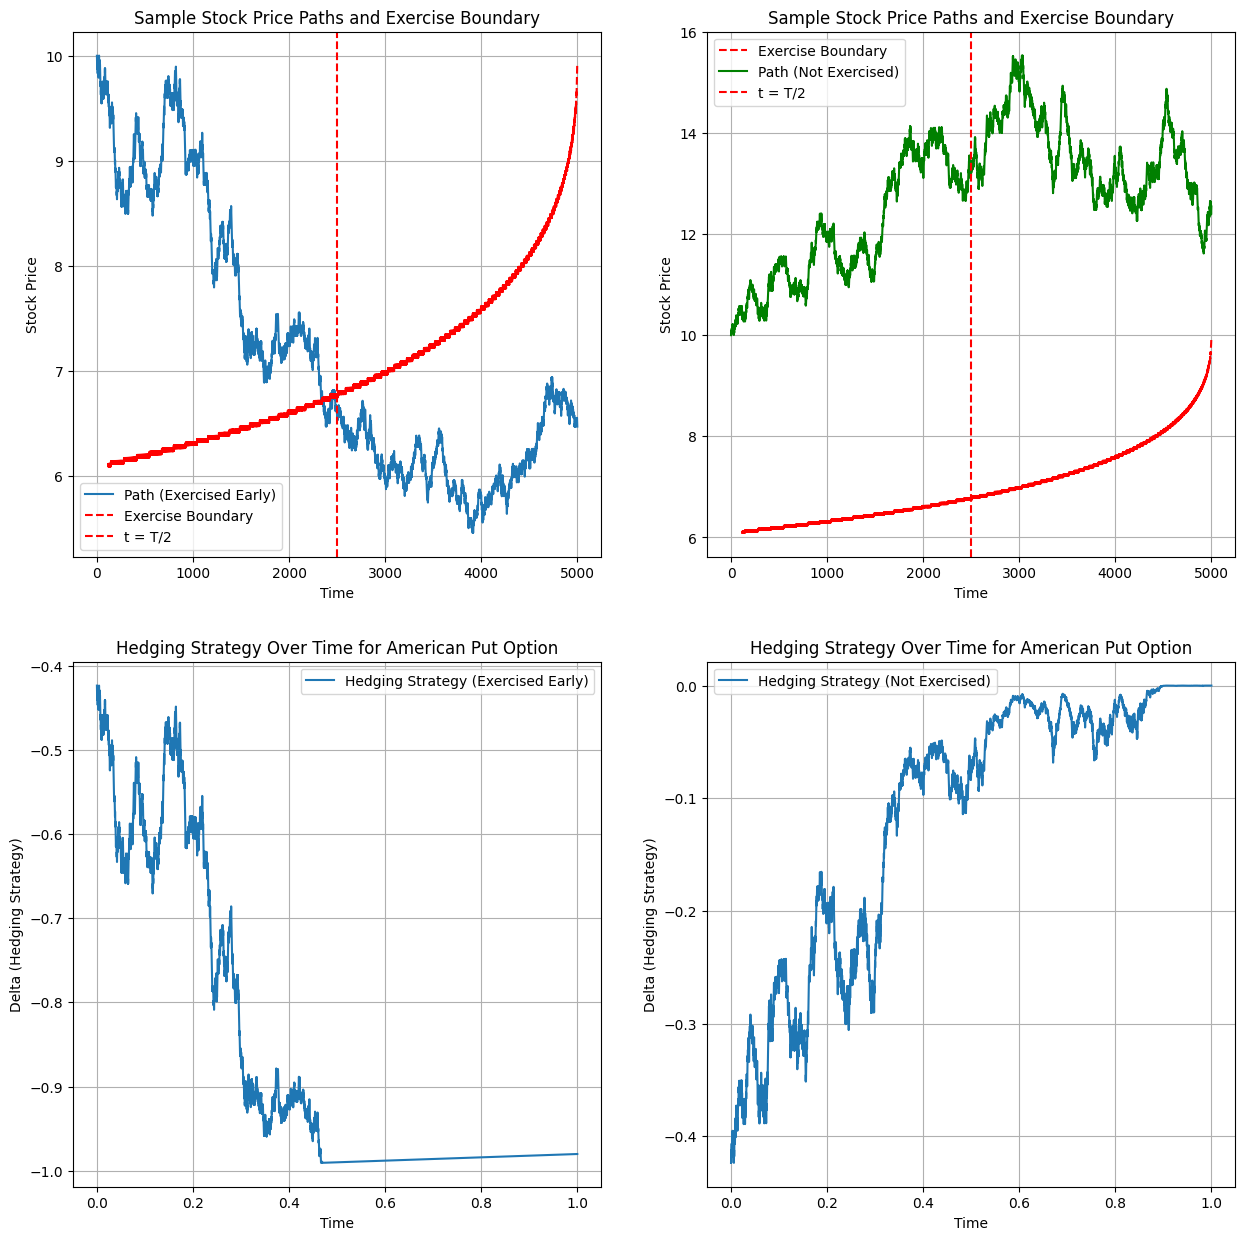

In [67]:
path_early_exercise_rn, path_no_exercise_rn = select_path(S0, N, u, d, P_real, exercise_boundary_rn,r,dt)


# Risk Neutral
delta_tree = calculate_delta(V1_rn, S, N)
hedge_early = get_hedging_strategy(path_early_exercise_rn, delta_tree, N)
hedge_no_exercise = get_hedging_strategy(path_no_exercise_rn, delta_tree, N)

# Risk Neutral
plot_boundary_delta(exercise_boundary_rn, path_early_exercise_rn,path_no_exercise_rn, hedge_early, hedge_no_exercise)

Higher r encourages early exercise to capture interest on the strike price. With higher interest rates (𝑟=4%), there is a stronger incentive to exercise early because the option holder benefits from receiving the strike price earlier and earning interest on that cash.
High volatility generally leads to less incentive for early exercise for an American put option. This is because increased volatility means there is a greater chance the stock price will drop further, making it more valuable to hold the option rather than exercise early, as the option's time value increases with volatility. Therefore, high volatility usually encourages the option holder to wait, reducing the likelihood of early exercise.

I will do a comparison with same volatility and higher r = 4% to show the impact of high interest rate.


Higher σ increases stock price volatility, leading to more frequent hedging adjustments and larger Delta fluctuations.

### sigma = 20%, r = 4%

In [68]:
# Parameters
S0 = 10      # Initial stock price
T = 1        # Time to maturity (in years)
sigma = 0.2 # Volatility
r = 0.04     # Risk-free rate
N = 5000       # Number of time steps (for this small example)
dt = T / N   # Time step size
mu = 0.05
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u    # Down factor
K = 10


In [69]:
S,V = build_stockoption_tree(S0, T, sigma, r, N)
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn

In [70]:
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn

P_real = 1/2 * (1 + ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
Q_real = 1/2 * (1 - ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)

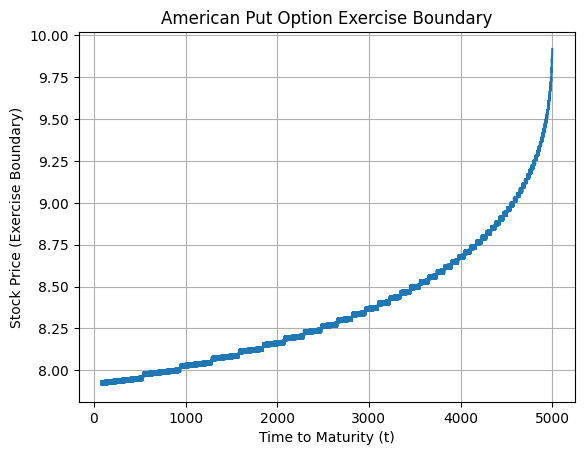

In [71]:
exercise_boundary_rn, V1_rn = cal_exercise_boundary(S, V, K, r, dt, P_rn, Q_rn)


plt.plot(list(exercise_boundary_rn.keys()), list(exercise_boundary_rn.values()), label = 'Risk Neutral')



plt.xlabel('Time to Maturity (t)')
plt.ylabel('Stock Price (Exercise Boundary)')
plt.title('American Put Option Exercise Boundary')
plt.grid(True)
plt.show()



Exercise Boundary:

Higher r=4%
The exercise boundary is higher, meaning the option holder is more likely to exercise early. This is consistent with the fact that a higher interest rate encourages early exercise to capture the strike price and reinvest at a higher return.
The holder has a greater incentive to exercise early, leading to a higher boundary.\
Comparing with the default, lower r=2%
The exercise boundary is lower, as there is less incentive to exercise early when the interest rate is lower. The holder can afford to wait longer before exercising the option.

In [72]:
print("The American put option price is: ", V1_rn[0][0])

The American put option price is:  0.640403210427336


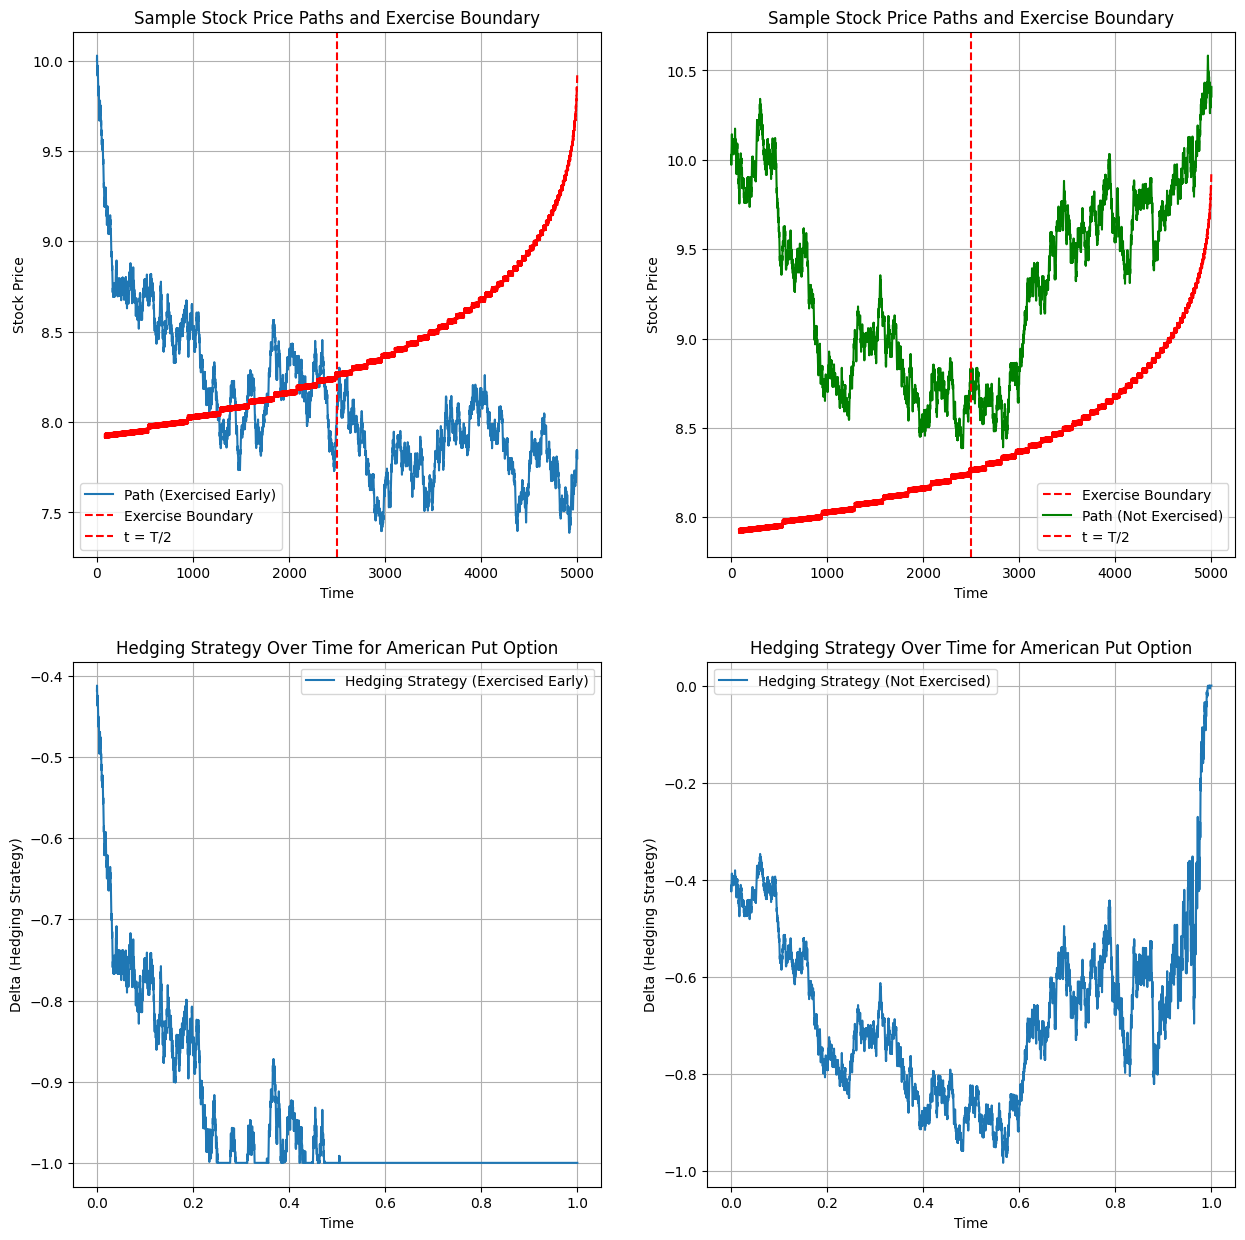

In [73]:
path_early_exercise_rn, path_no_exercise_rn = select_path(S0, N, u, d, P_real, exercise_boundary_rn,r,dt)


# Risk Neutral
delta_tree = calculate_delta(V1_rn, S, N)
hedge_early = get_hedging_strategy(path_early_exercise_rn, delta_tree, N)
hedge_no_exercise = get_hedging_strategy(path_no_exercise_rn, delta_tree, N)

# Risk Neutral
plot_boundary_delta(exercise_boundary_rn, path_early_exercise_rn,path_no_exercise_rn, hedge_early, hedge_no_exercise)

Hedging Strategy (Delta):

We typically should expect with higher interest rate = 4%, we should exercise earlier than the case with lower interest rate, but the plot only shows one sample path for the early exercise case.




## Q2 b

(i)

In [74]:
# Parameters
S0 = 10      # Initial stock price
T = 1        # Time to maturity (in years)
sigma = 0.20 # Volatility
r = 0.02     # Risk-free rate
N = 5000       # Number of time steps (for this small example)
dt = T / N   # Time step size
mu = 0.05
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u    # Down factor
K = 10


In [75]:
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn
P_real = 1/2 * (1 + ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
Q_real = 1/2 * (1 - ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)


S,V = build_stockoption_tree(S0, T, sigma, r, N)
exercise_boundary_rn, V1_rn = cal_exercise_boundary(S, V, K, r, dt, P_rn, Q_rn)

# sort the dictionary by key
exercise_boundary_rn = dict(sorted(exercise_boundary_rn.items()))

In [76]:
def simulate_PnL_Stopping_time(S0, N, u, d, P, exercise_boundary_rn, K, V,r,dt):

    # simulate 10,000 sample path of stocks, based on that get the P&L of the option
    n_paths = 10000
    paths = simulate_stock_paths(S0, N, u, d, P, n_paths, r, dt)

    PL = [None] * n_paths
    stopping_times = [None] * n_paths
    for i in range(n_paths):
        for t in list(exercise_boundary_rn.keys()):
            if paths[i, t] <= exercise_boundary_rn[t]:
                PL[i] = np.exp(r*(1-t/N)) * (K - paths[i, t]) - V[0][0] # P&L is the intrinsic value at exercise
                stopping_times[i] = t/N  # Record stopping time

                break  # Exit loop once exercise happens
        if  all(paths[i, t] > exercise_boundary_rn[t] for t in list(exercise_boundary_rn.keys())): # no early exercise  # Compute payoff at expiration if in-the-money
            if max(K - paths[i, -1], 0) > 0: # In the money at maturity
                PL[i] = max(K - paths[i, -1], 0) - V[0][0]
                stopping_times[i] = N/N



    # remove all none values
    PL = [x for x in PL if x is not None]
    stopping_times = [x for x in stopping_times if x is not None]
    exercise_probability = len(stopping_times) / n_paths

    # Output results: P&L, stopping times, and exercise probability



    print("Average P&L:", np.mean(PL))
    print("Exercise Probability:", exercise_probability)

    # histogram of stopping time

    plt.hist(stopping_times, bins=50, edgecolor='black')
    plt.xlabel('Stopping Time')
    plt.ylabel('Frequency')
    plt.title('Stopping Time Distribution')
    plt.grid(True)
    plt.show()
    # plot a histogram of the P&L
    plt.hist(PL, bins=50, edgecolor='black')
    plt.xlabel('P&L')
    plt.ylabel('Frequency')
    plt.title('P&L Distribution of American Put Option')
    plt.grid(True)
    plt.show()

    # print the number of 0 payoff in the P&L
    print("Number of zero-payoff in P&L:", PL.count(V[0][0]))




Average P&L: 0.6731019071608758
Exercise Probability: 0.4552


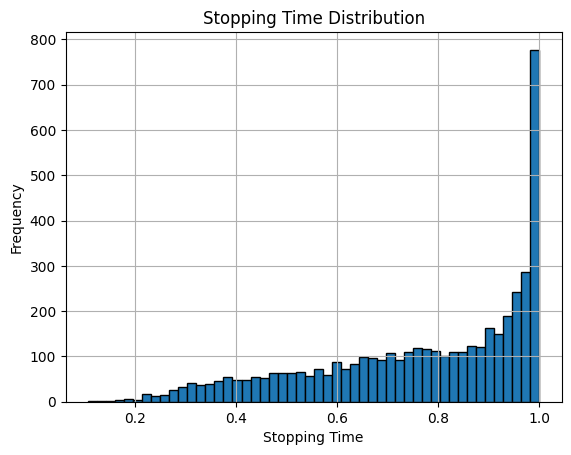

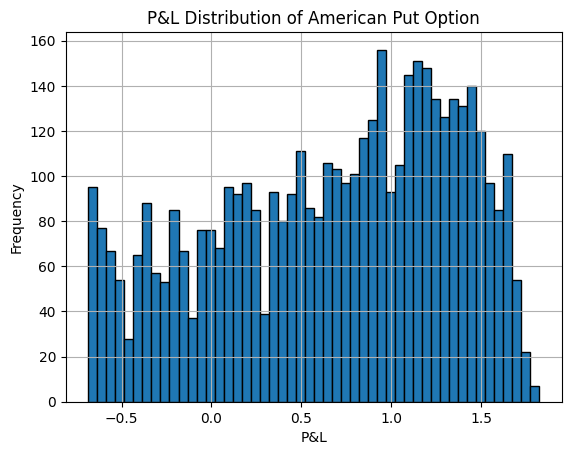

Number of zero-payoff in P&L: 0


In [77]:
simulate_PnL_Stopping_time(S0, N, u, d, P_real, exercise_boundary_rn, K, V1_rn,r,dt)

### Comparison Q2b (ii)

### sigma = 10%, r = 0%

In [78]:
# Parameters
S0 = 10      # Initial stock price
T = 1        # Time to maturity (in years)
sigma = 0.1 # Volatility
r = 0    # Risk-free rate
N = 5000       # Number of time steps (for this small example)
dt = T / N   # Time step size
mu = 0.05
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u    # Down factor
K = 10

In [79]:
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn
P_real = 1/2 * (1 + ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
Q_real = 1/2 * (1 - ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
S,V = build_stockoption_tree(S0, T, sigma, r, N)
exercise_boundary_rn, V1_rn = cal_exercise_boundary(S, V, K, r, dt, P_rn, Q_rn)

# sort the dictionary by key
exercise_boundary_rn = dict(sorted(exercise_boundary_rn.items()))

Average P&L: 0.24378971434008723
Exercise Probability: 0.3244


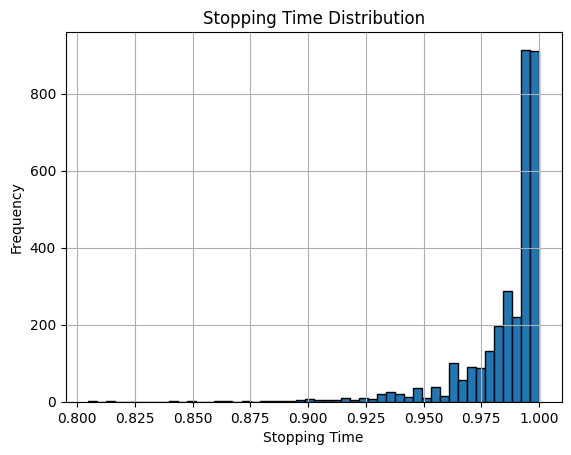

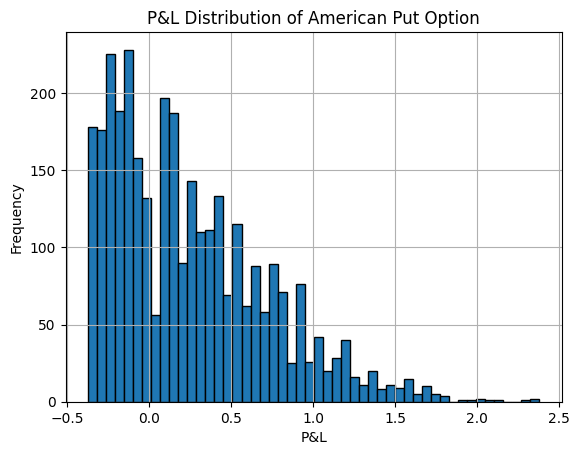

Number of zero-payoff in P&L: 0


In [80]:
simulate_PnL_Stopping_time(S0, N, u, d, P_real, exercise_boundary_rn, K, V1_rn,r,dt)

Here we see there is barely no early exercise, since the exercise boundary is so low, the stopping times are very close to 1. This is consistent with the previous observation of r = 0 implies not encouraging early exercise. Also, since the volatility is low, we expect low payoff.

### sigma = 30%, r = 4%

In [81]:
# Parameters
S0 = 10      # Initial stock price
T = 1        # Time to maturity (in years)
sigma = 0.3 # Volatility
r = 0.04    # Risk-free rate
N = 5000       # Number of time steps (for this small example)
dt = T / N   # Time step size
mu = 0.05
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u    # Down factor
K = 10

In [82]:
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn
P_real = 1/2 * (1 + ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
Q_real = 1/2 * (1 - ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
S,V = build_stockoption_tree(S0, T, sigma, r, N)
exercise_boundary_rn, V1_rn = cal_exercise_boundary(S, V, K, r, dt, P_rn, Q_rn)

# sort the dictionary by key
exercise_boundary_rn = dict(sorted(exercise_boundary_rn.items()))

Average P&L: 0.9895978613362413
Exercise Probability: 0.5139


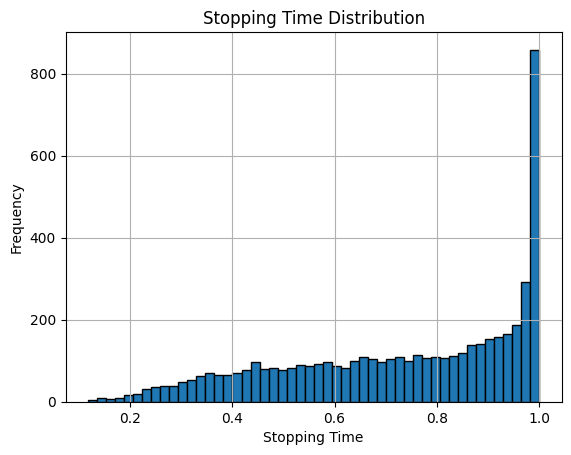

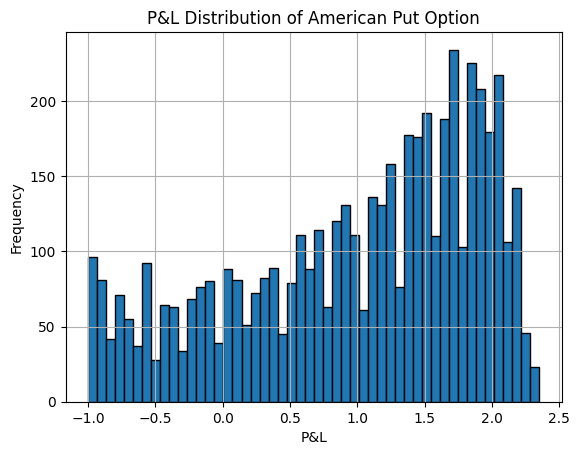

Number of zero-payoff in P&L: 0


In [83]:
simulate_PnL_Stopping_time(S0, N, u, d, P_real, exercise_boundary_rn, K, V1_rn,r,dt)

High Volatility leads to potential more profit, and high r lead to more exercise early.

### sigma = 20%, r = 5%

In [84]:
# Parameters
S0 = 10      # Initial stock price
T = 1        # Time to maturity (in years)
sigma = 0.2 # Volatility
r = 0.05    # Risk-free rate
N = 5000       # Number of time steps (for this small example)
dt = T / N   # Time step size
mu = 0.05
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u    # Down factor
K = 10

In [85]:
P_rn = 1/(np.exp(sigma*np.sqrt(dt))+1)
Q_rn = 1-P_rn
P_real = 1/2 * (1 + ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
Q_real = 1/2 * (1 - ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
S,V = build_stockoption_tree(S0, T, sigma, r, N)
exercise_boundary_rn, V1_rn = cal_exercise_boundary(S, V, K, r, dt, P_rn, Q_rn)

# sort the dictionary by key
exercise_boundary_rn = dict(sorted(exercise_boundary_rn.items()))

Average P&L: 0.6943751238909023
Exercise Probability: 0.4961


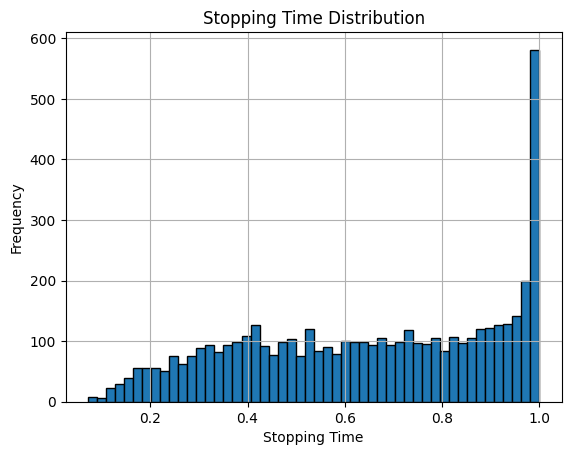

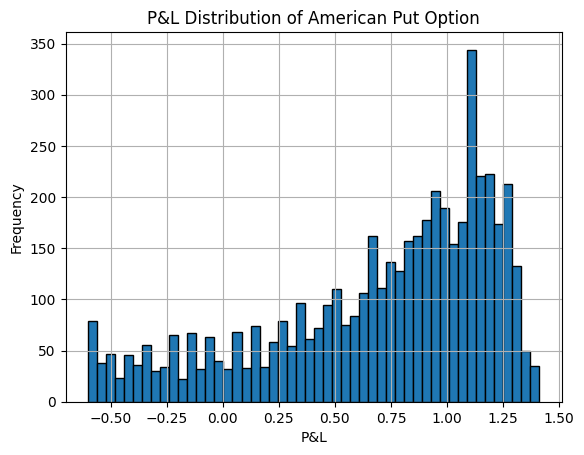

Number of zero-payoff in P&L: 0


In [86]:
simulate_PnL_Stopping_time(S0, N, u, d, P_real, exercise_boundary_rn, K, V1_rn,r,dt)

Here we see more early exercise (some even at T around 0.2) since r is high, which is consistent with previous observations. However, since volatility is 20% < 30% to the previous case, it has a lower probability overall to mature in the money so overall exercise probability is lower than the case with vol = 30%.

### Q2b (iii)

### sigma = 10%

In [87]:
# Parameters
S0 = 10      # Initial stock price
T = 1        # Time to maturity (in years)
sigma = 0.1 # Volatility
r = 0.02    # Risk-free rate
N = 5000       # Number of time steps (for this small example)
dt = T / N   # Time step size
mu = 0.05
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u    # Down factor
K = 10

In [88]:
# we used sigma = 0.2

sigma_1 = 0.2
P_rn = 1/(np.exp(sigma_1*np.sqrt(dt))+1)
Q_rn = 1-P_rn

In [89]:
P_real = 1/2 * (1 + ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
Q_real = 1/2 * (1 - ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
S,V = build_stockoption_tree(S0, T, sigma_1, r, N)
exercise_boundary_rn, V1_rn = cal_exercise_boundary(S, V, K, r, dt, P_rn, Q_rn)

# sort the dictionary by key
exercise_boundary_rn = dict(sorted(exercise_boundary_rn.items()))

Average P&L: -0.06785593801257093
Exercise Probability: 0.3197


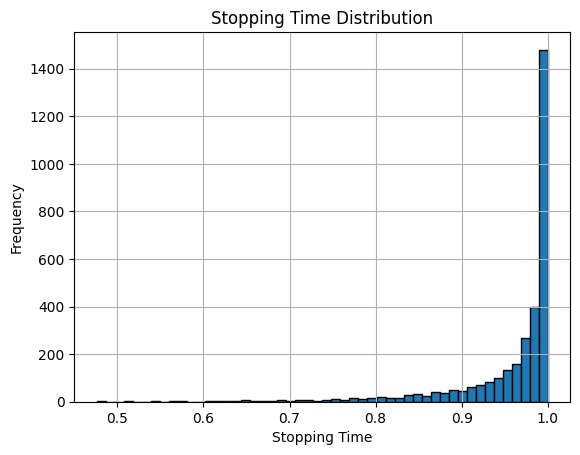

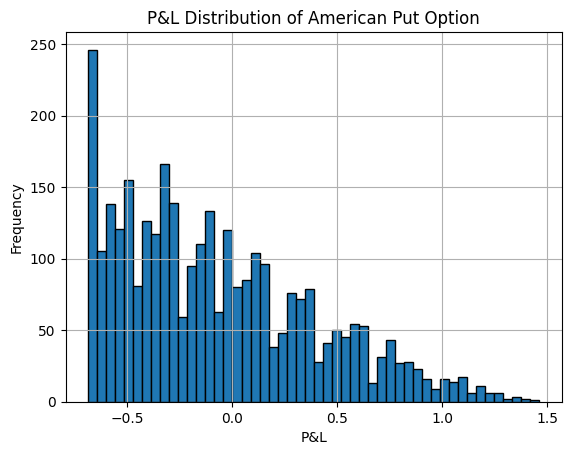

Number of zero-payoff in P&L: 0


In [90]:
simulate_PnL_Stopping_time(S0, N, u, d, P_real, exercise_boundary_rn, K, V1_rn,r,dt)

Here the implied volatility is lower than we expected, The stock price is less volatile than expected.
Lower probability of the stock price falling significantly below the strike price.
Potentially fewer profitable opportunities to exercise the option.
Also for higher volatility, we priced the option with a higher price so the profit is lower.
Option may expire worthless or with less profit than anticipated. So lower exercise probability and lower profit


### sigma = 15%


In [91]:
# Parameters
S0 = 10      # Initial stock price
T = 1        # Time to maturity (in years)
sigma = 0.15 # Volatility
r = 0.02    # Risk-free rate
N = 5000       # Number of time steps (for this small example)
dt = T / N   # Time step size
mu = 0.05
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u    # Down factor
K = 10

In [92]:
P_real = 1/2 * (1 + ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
Q_real = 1/2 * (1 - ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)



Average P&L: 0.30310347115394504
Exercise Probability: 0.3987


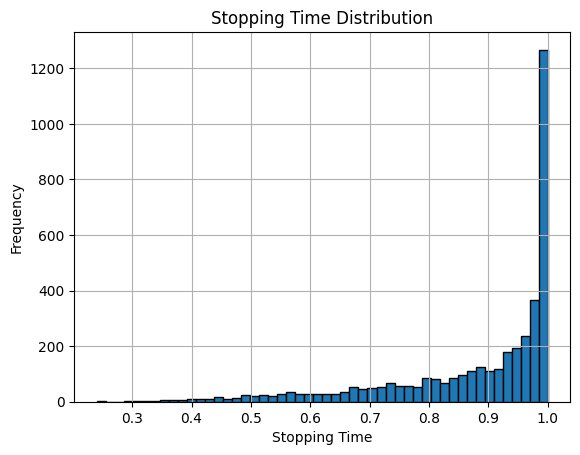

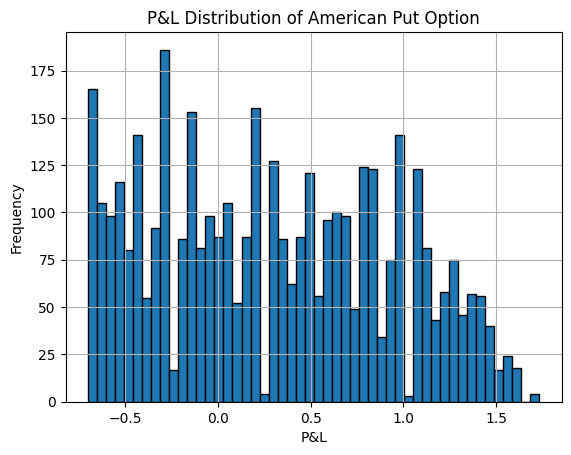

Number of zero-payoff in P&L: 0


In [93]:
simulate_PnL_Stopping_time(S0, N, u, d, P_real, exercise_boundary_rn, K, V1_rn,r,dt)

Same logic. While in this case we have a even lower profit, but exercised more, since sigma is more closer to our expected sigma.

### Sigma = 25%

In [94]:
# Parameters
S0 = 10      # Initial stock price
T = 1        # Time to maturity (in years)
sigma = 0.25 # Volatility
r = 0.02    # Risk-free rate
N = 5000       # Number of time steps (for this small example)
dt = T / N   # Time step size
mu = 0.05
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u    # Down factor
K = 10

In [95]:
P_real = 1/2 * (1 + ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
Q_real = 1/2 * (1 - ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)

Average P&L: 0.9150060844137319
Exercise Probability: 0.5052


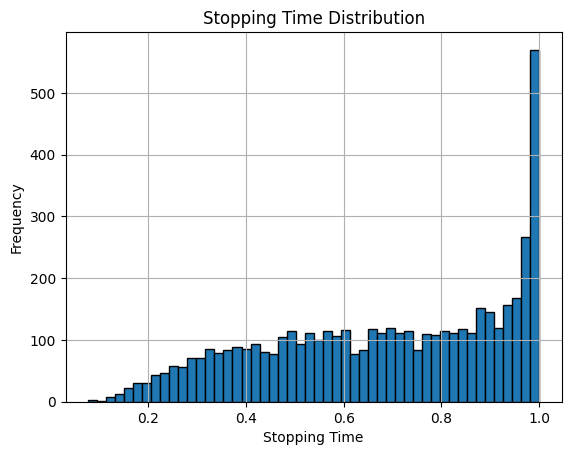

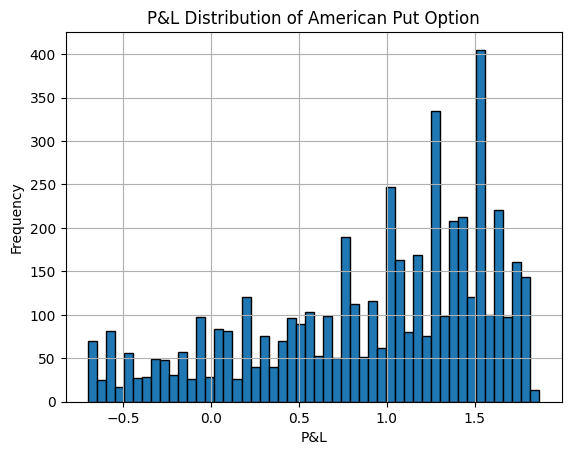

Number of zero-payoff in P&L: 0


In [96]:
simulate_PnL_Stopping_time(S0, N, u, d, P_real, exercise_boundary_rn, K, V1_rn,r,dt)

Higher Realized Volatility:

The stock price is more volatile than expected.
Higher probability of the stock price falling significantly below the strike price.
More opportunities to profitably exercise the option.
Potential for greater profits than anticipated.
Also, we priced the option using sigma = 20%, so in this case is underpriced , so the profit is higher.
Exercise probability increase.

### Sigma = 30%

In [97]:
# Parameters
S0 = 10      # Initial stock price
T = 1        # Time to maturity (in years)
sigma = 0.30 # Volatility
r = 0.02    # Risk-free rate
N = 5000       # Number of time steps (for this small example)
dt = T / N   # Time step size
mu = 0.05
u = np.exp(sigma * np.sqrt(dt))  # Up factor
d = 1 / u    # Down factor
K = 10

In [98]:
P_real = 1/2 * (1 + ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)
Q_real = 1/2 * (1 - ((mu - r)- 1/2 * sigma**2) * np.sqrt(dt)/sigma)

Average P&L: 1.1095080582756014
Exercise Probability: 0.5517


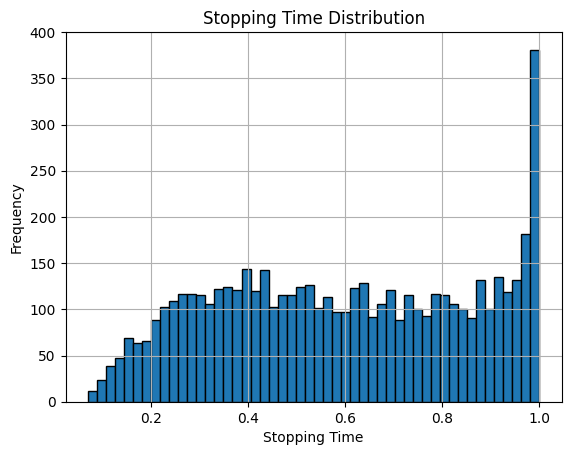

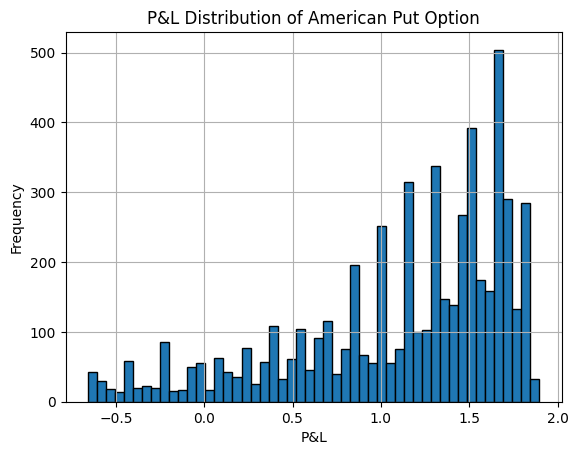

Number of zero-payoff in P&L: 0


In [99]:
simulate_PnL_Stopping_time(S0, N, u, d, P_real, exercise_boundary_rn, K, V1_rn,r,dt)

Same logic.